## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-08-27 14:11:21.558709: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 14:11:22.583240: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 14:11:23.618003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib 

In [6]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *


#### Check job specs

In [7]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 13.2%
RAM Usage: 10.1%
Available RAM: 1.3T
Total RAM: 1.5T
52.4G


## Wandb API Query <a id="sims"></a>

In [82]:
import wandb
from datetime import datetime, timedelta

api = wandb.Api()

project_path = "alexander-ratzan-new-york-university/gx2conn"

models = ['cge', 'gaussian_kernel', 'exponential_decay', 'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
model_groups = {'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'], 
'bilinear': ['bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank'], 
'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']}

cv_types = ['random', 'spatial']
feature_types = ['euclidean', 'transcriptome', 'transcriptome_PCA']
null_model = ['none', 'spin']
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
folds = [0, 1, 2, 3]


model = 'dynamic_mlp'
cv_type = 'schaefer'
null_model = 'none'
feature_type = 'transcriptome+euclidean'

time_filter = datetime.now() - timedelta(days=1)

filters = {
    "tags": {
        "$all": [
            "final_eval",
            f"model_{model}",
            f"cv_type_{cv_type}",
            f"null_model_{null_model}",
            f"feature_type_{feature_type}"
        ]
    },
    "created_at": {"$gte": time_filter.isoformat()},
    "state": "finished"
}

runs = api.runs(project_path, filters=filters, order="-created_at")
run_data = []
for run in runs:
    # Extract all metrics from final_train_metrics and final_test_metrics
    metrics = {}
    
    if 'final_train_metrics' in run.summary:
        for k, v in run.summary['final_train_metrics'].items():
            metrics[f'train_{k}'] = v
            
    if 'final_test_metrics' in run.summary:
        for k, v in run.summary['final_test_metrics'].items():
            metrics[f'test_{k}'] = v
    
    run_info = {
        'run_name': run.name,
        **metrics
    }
    run_data.append(run_info)

df = pd.DataFrame(run_data)
print(f"\nDataFrame created with {len(df)} runs")
print(f"Columns: {list(df.columns)}")


DataFrame created with 18 runs
Columns: ['run_name', 'train_geodesic_distance', 'train_inter_hemi_r', 'train_inter_network_Cerebellum_r', 'train_inter_network_Cont_r', 'train_inter_network_Default_r', 'train_inter_network_DorsAttn_r', 'train_inter_network_Limbic_r', 'train_inter_network_SalVentAttn_r', 'train_inter_network_SomMot_r', 'train_inter_network_Subcortical_r', 'train_inter_network_Vis_r', 'train_intra_network_Cerebellum_r', 'train_intra_network_Cont_r', 'train_intra_network_Default_r', 'train_intra_network_DorsAttn_r', 'train_intra_network_Limbic_r', 'train_intra_network_SalVentAttn_r', 'train_intra_network_SomMot_r', 'train_intra_network_Subcortical_r', 'train_intra_network_Vis_r', 'train_left_hemi_r', 'train_long_r', 'train_mae', 'train_mid_r', 'train_mse', 'train_pearson_r', 'train_r2', 'train_right_hemi_r', 'train_short_r', 'train_spearman_r', 'train_strong_neg_r', 'train_strong_pos_r', 'train_weak_r', 'test_inter_network_Cerebellum_r', 'test_inter_network_Cont_r', 'test

Search and plot Schaefer

In [110]:
from collections import defaultdict
# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

cv_type = 'schaefer'
null_model = 'none'
within_last = 60
before_last = -1 # guaranteed to find most recent runs

# Store summary DataFrames
summary_dict_schaefer = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_schaefer, within_last=within_last, before_last=before_last)

cv_type = 'schaefer'
null_model = 'spin'

# Store summary DataFrames
summary_dict_schaefer_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_schaefer_spin, within_last=within_last, before_last=before_last)

Checking which model/feature type combinations return 9 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

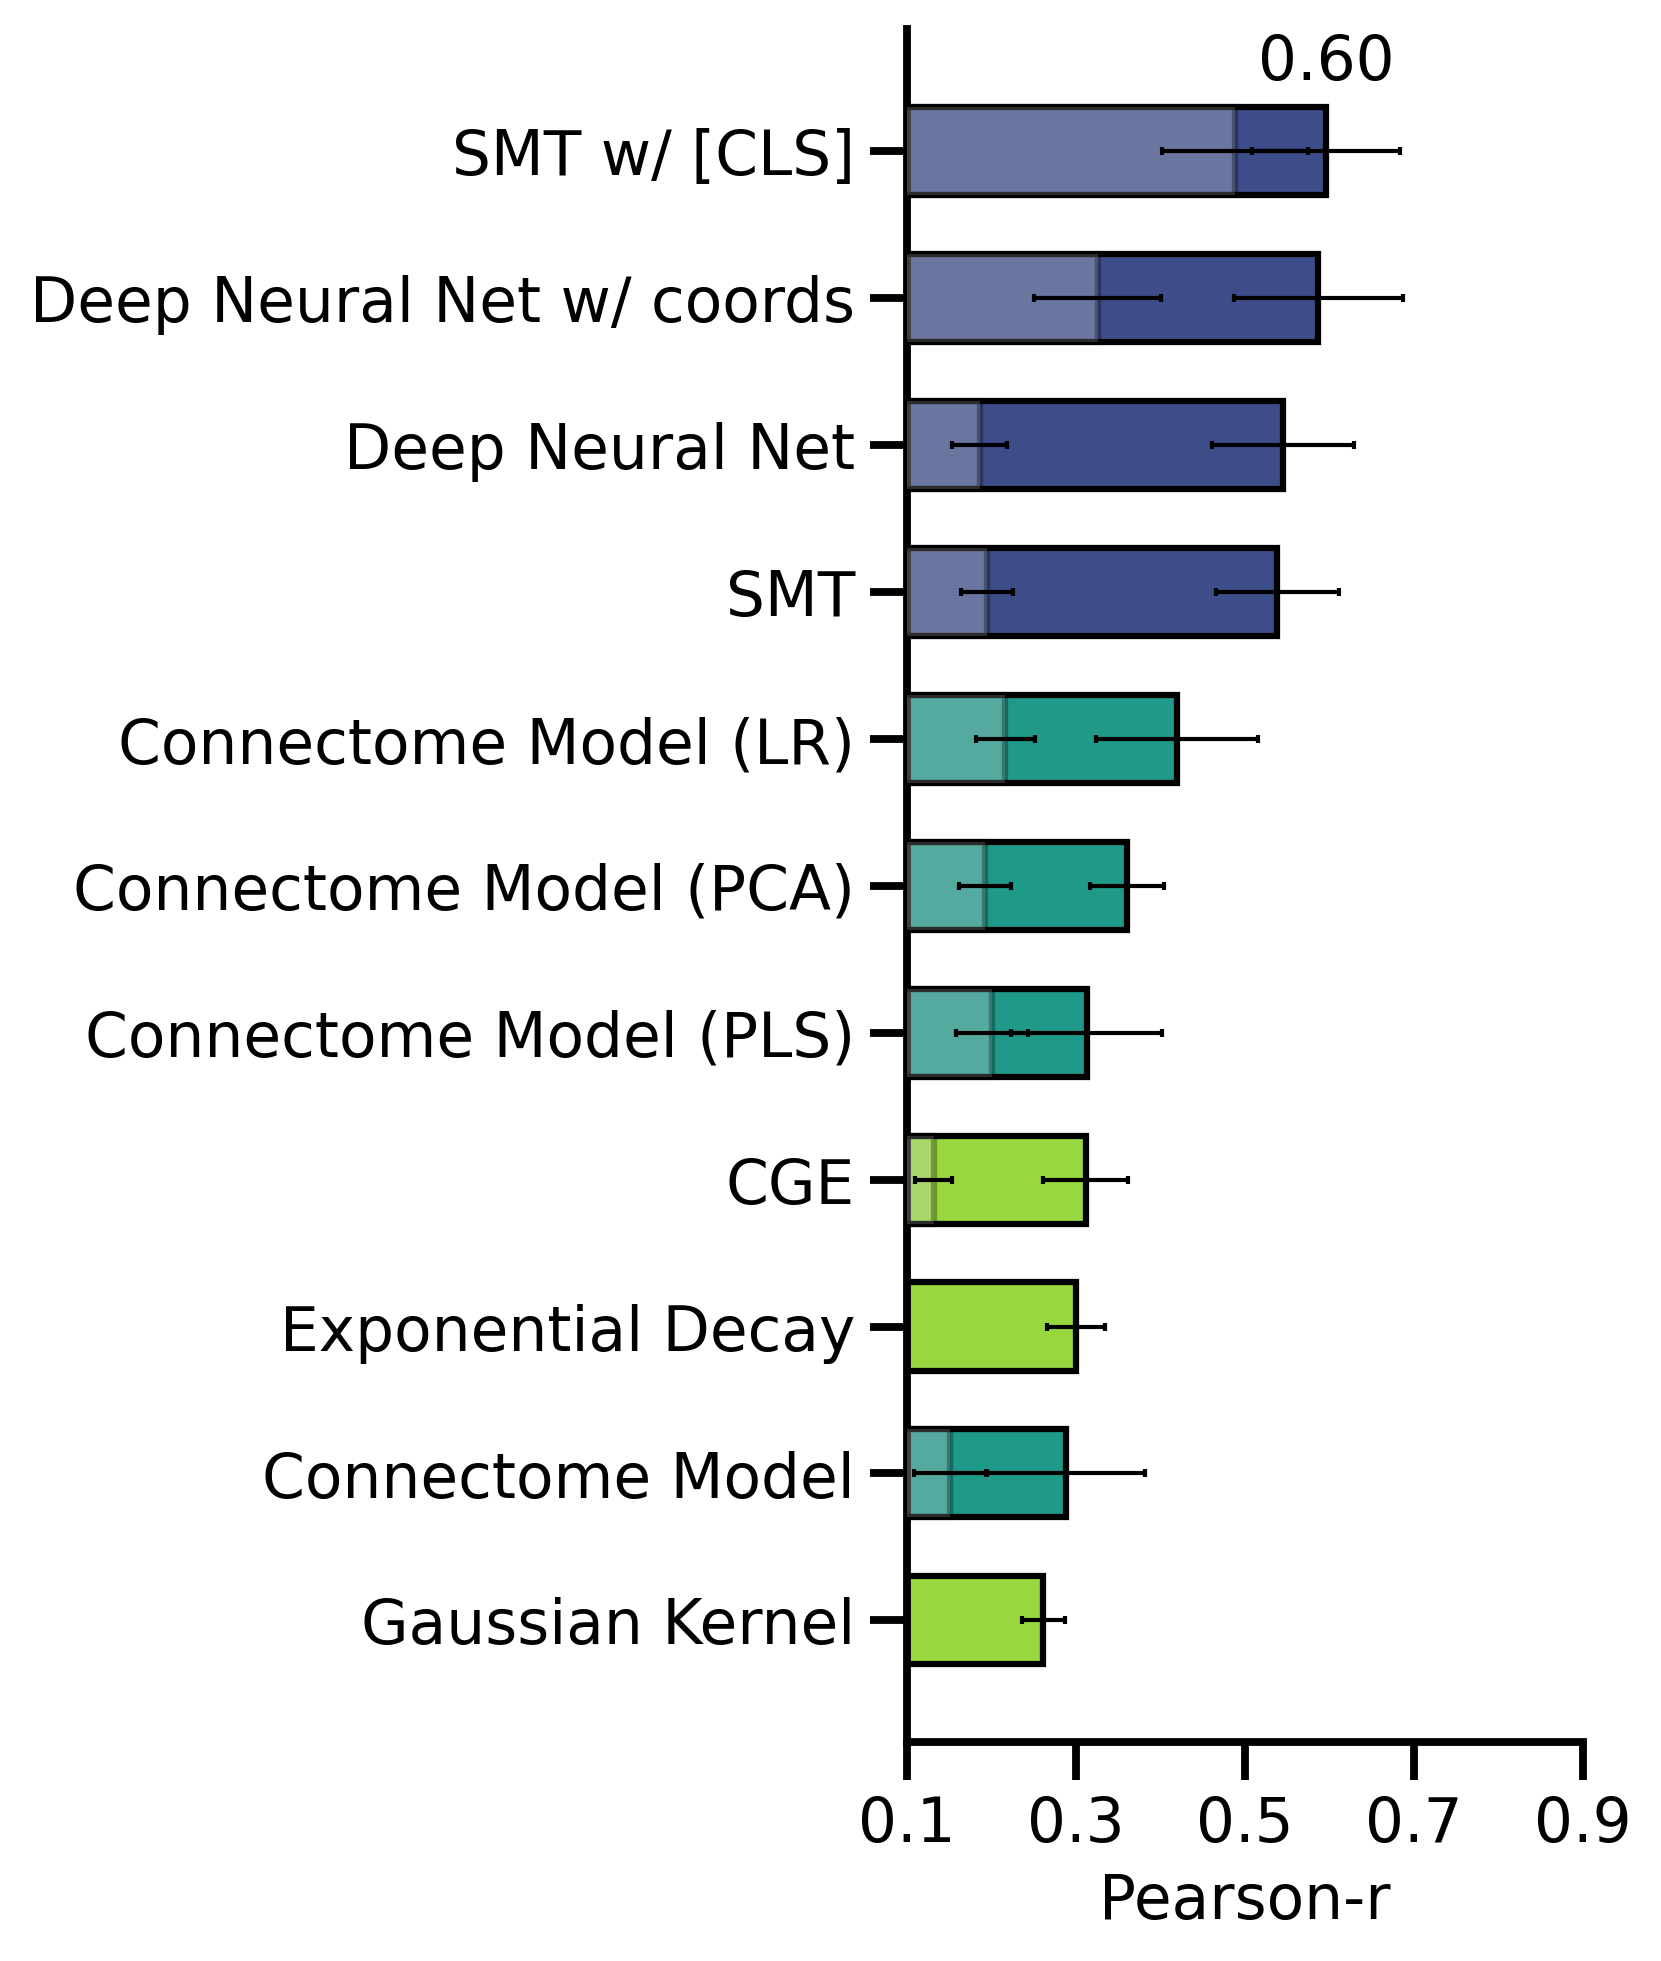

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [111]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_schaefer,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_schaefer_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Continue from here with weighted averaging for schaefer plot... 

In [113]:
cv_type = 'schaefer'
null_model = 'none'
within_last = 60
before_last = -1 # guaranteed to find most recent runs

# Store summary DataFrames
summary_dict_schaefer = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_schaefer, within_last=within_last, before_last=before_last, use_weighted=True)

cv_type = 'schaefer'
null_model = 'spin'

# Store summary DataFrames
summary_dict_schaefer_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_schaefer_spin, within_last=within_last, before_last=before_last, use_weighted=True)

Checking which model/feature type combinations return 9 runs for null_model=none (weighted):

🔍 Fetching runs for: model=cge, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ pls_bilineardecode

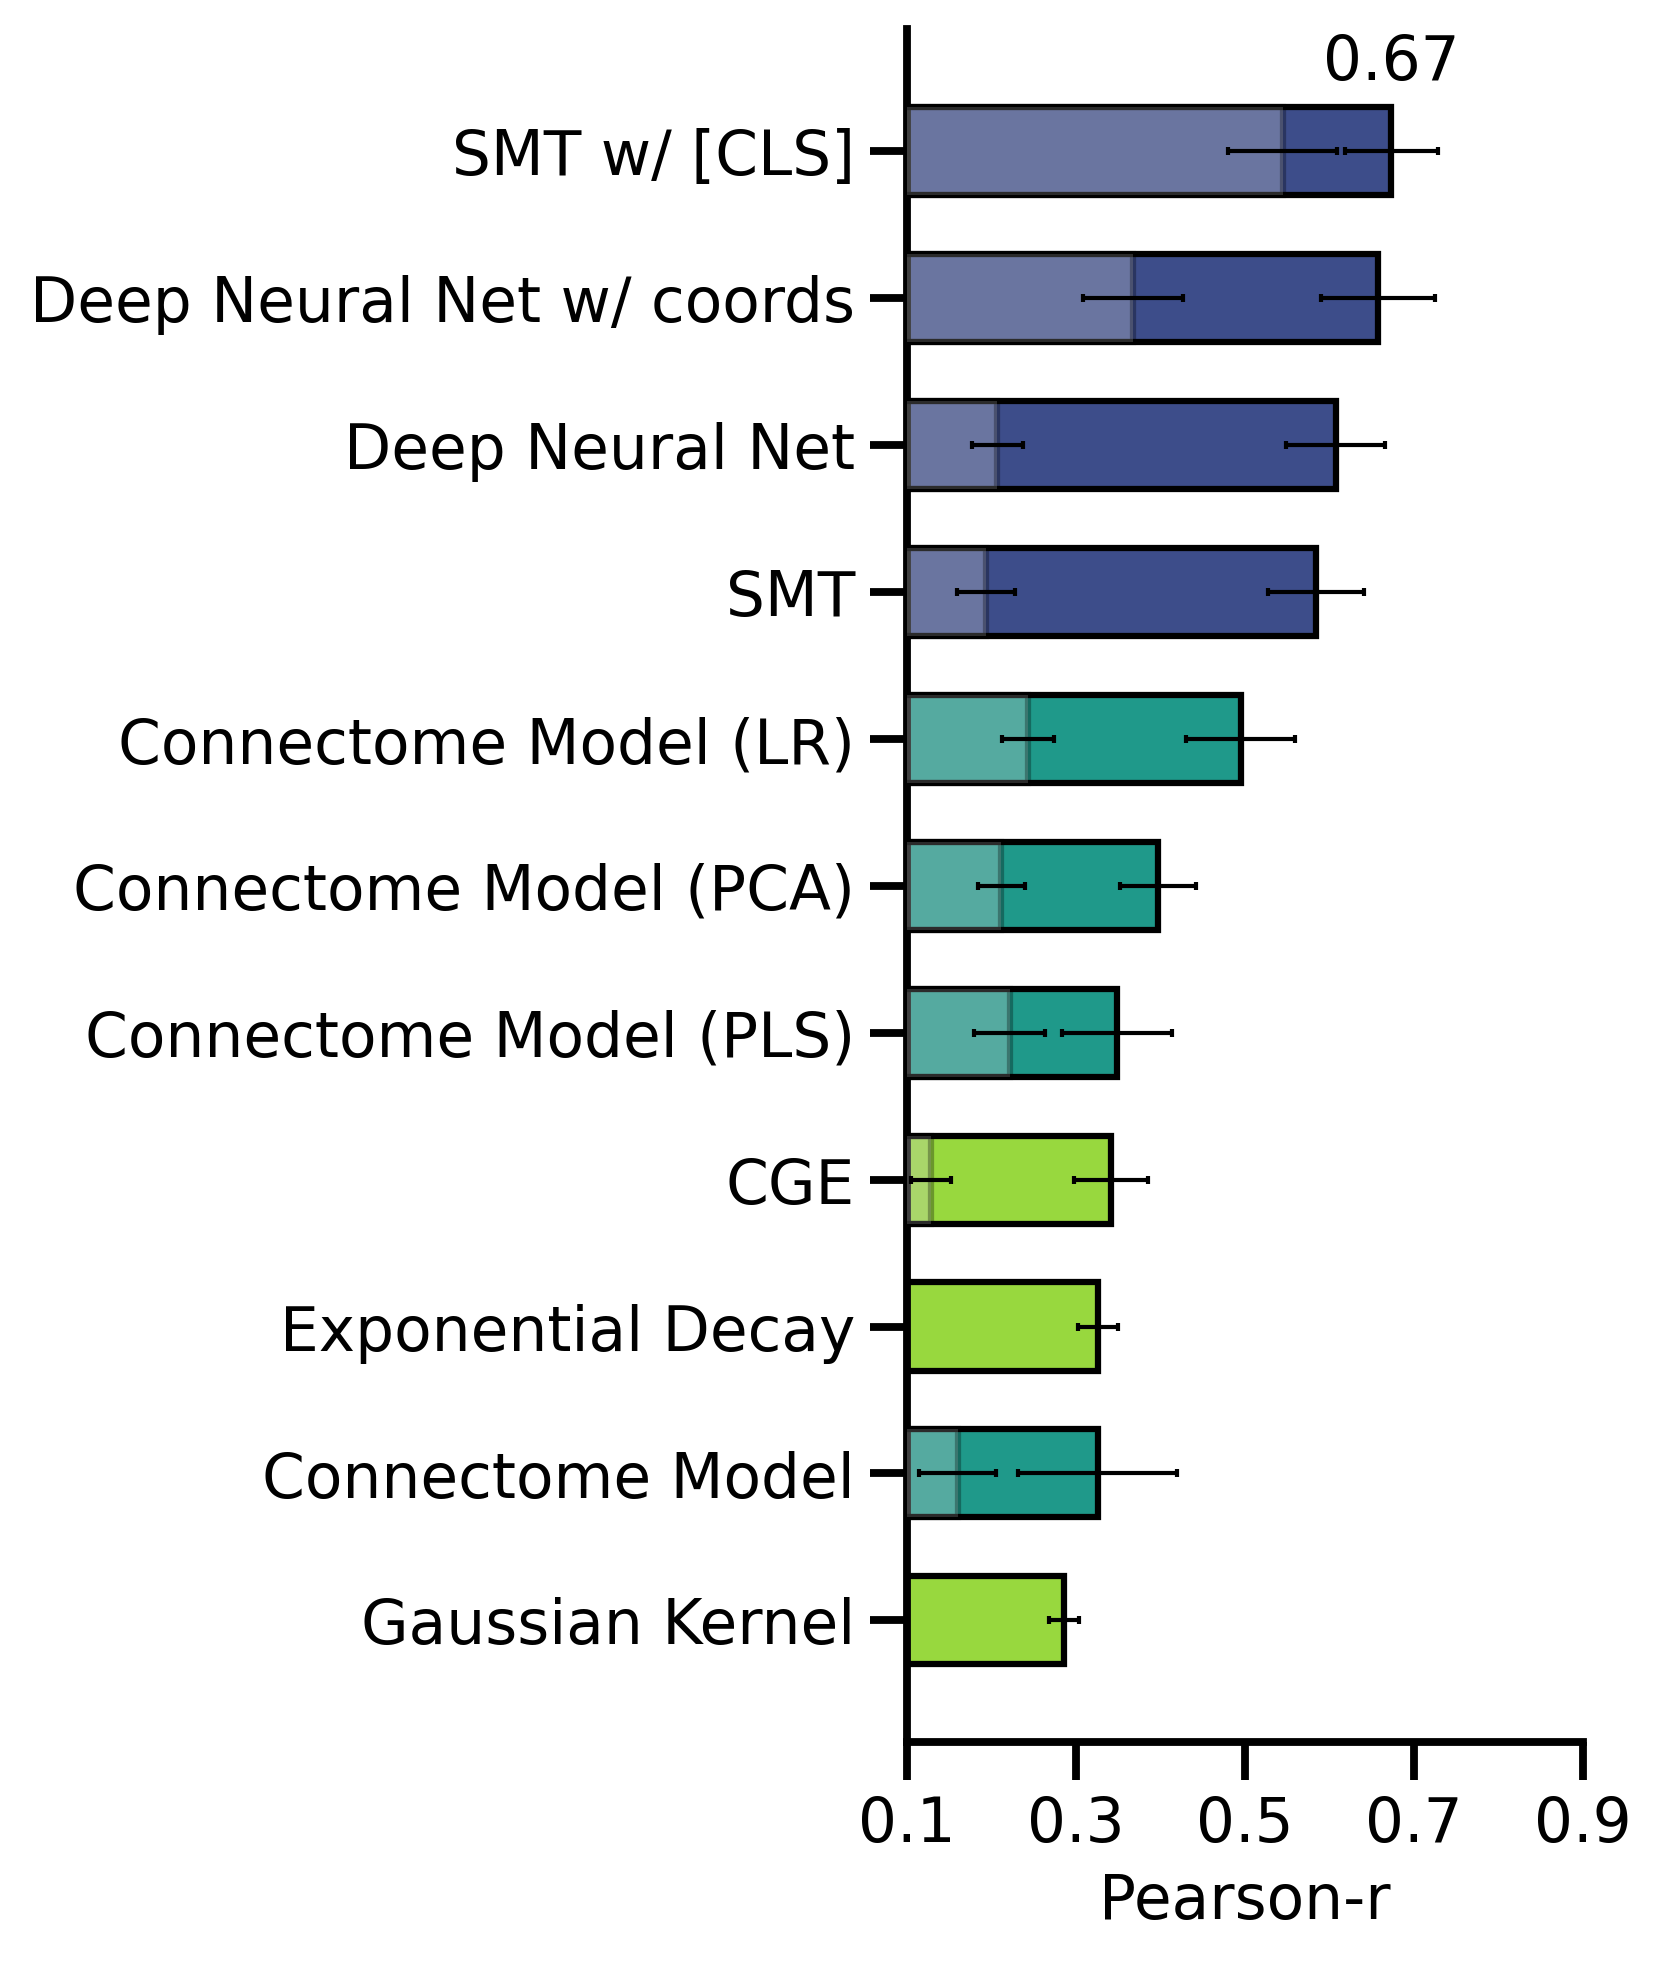

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [114]:
plot_true_vs_null_model_barchart_weighted(
    summary_true_dict=summary_dict_schaefer,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_schaefer_spin,           # cv_type='spatial', null_model='spin'
    metric="final_test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Lobe split

In [13]:
# Define model groups and their valid feature types
models = ['bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

In [14]:
cv_type = 'lobe'
null_model = 'none'
days = 10

# Store summary DataFrames for schaefer with no null model
summary_dict_lobe = {}
process_model_feature_combinations(
    cv_type=cv_type,
    null_model=null_model, 
    days=days,
    models=models,
    model_feature_types=model_feature_types,
    summary_dict=summary_dict_lobe, 
    use_weighted=True
)

# Store summary DataFrames for schaefer with spin null model
null_model = 'spin'
summary_dict_lobe_spin = {}
process_model_feature_combinations(
    cv_type=cv_type,
    null_model=null_model,
    days=days, 
    models=models,
    model_feature_types=model_feature_types,
    summary_dict=summary_dict_lobe_spin, 
    use_weighted=True
)

Checking which model/feature type combinations return 6 runs for null_model=none (weighted):

🔍 Fetching runs for: model=bilinear_lowrank, cv_type=lobe, null_model=none, feature_type=transcriptome
✓ bilinear_lowrank with transcriptome: Successfully found 6 runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=lobe, null_model=none, feature_type=transcriptome
✓ dynamic_mlp: Successfully found 6 runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=lobe, null_model=none, feature_type=transcriptome+euclidean
✓ dynamic_mlp_coords: Successfully found 6 runs
🔍 Fetching runs for: model=shared_transformer, cv_type=lobe, null_model=none, feature_type=transcriptome
✓ shared_transformer with transcriptome: Successfully found 6 runs
🔍 Fetching runs for: model=shared_transformer_cls, cv_type=lobe, null_model=none, feature_type=transcriptome
✓ shared_transformer_cls with transcriptome: Successfully found 6 runs
Checking which model/feature type combinations return 6 runs for null_model=spin (weighted)

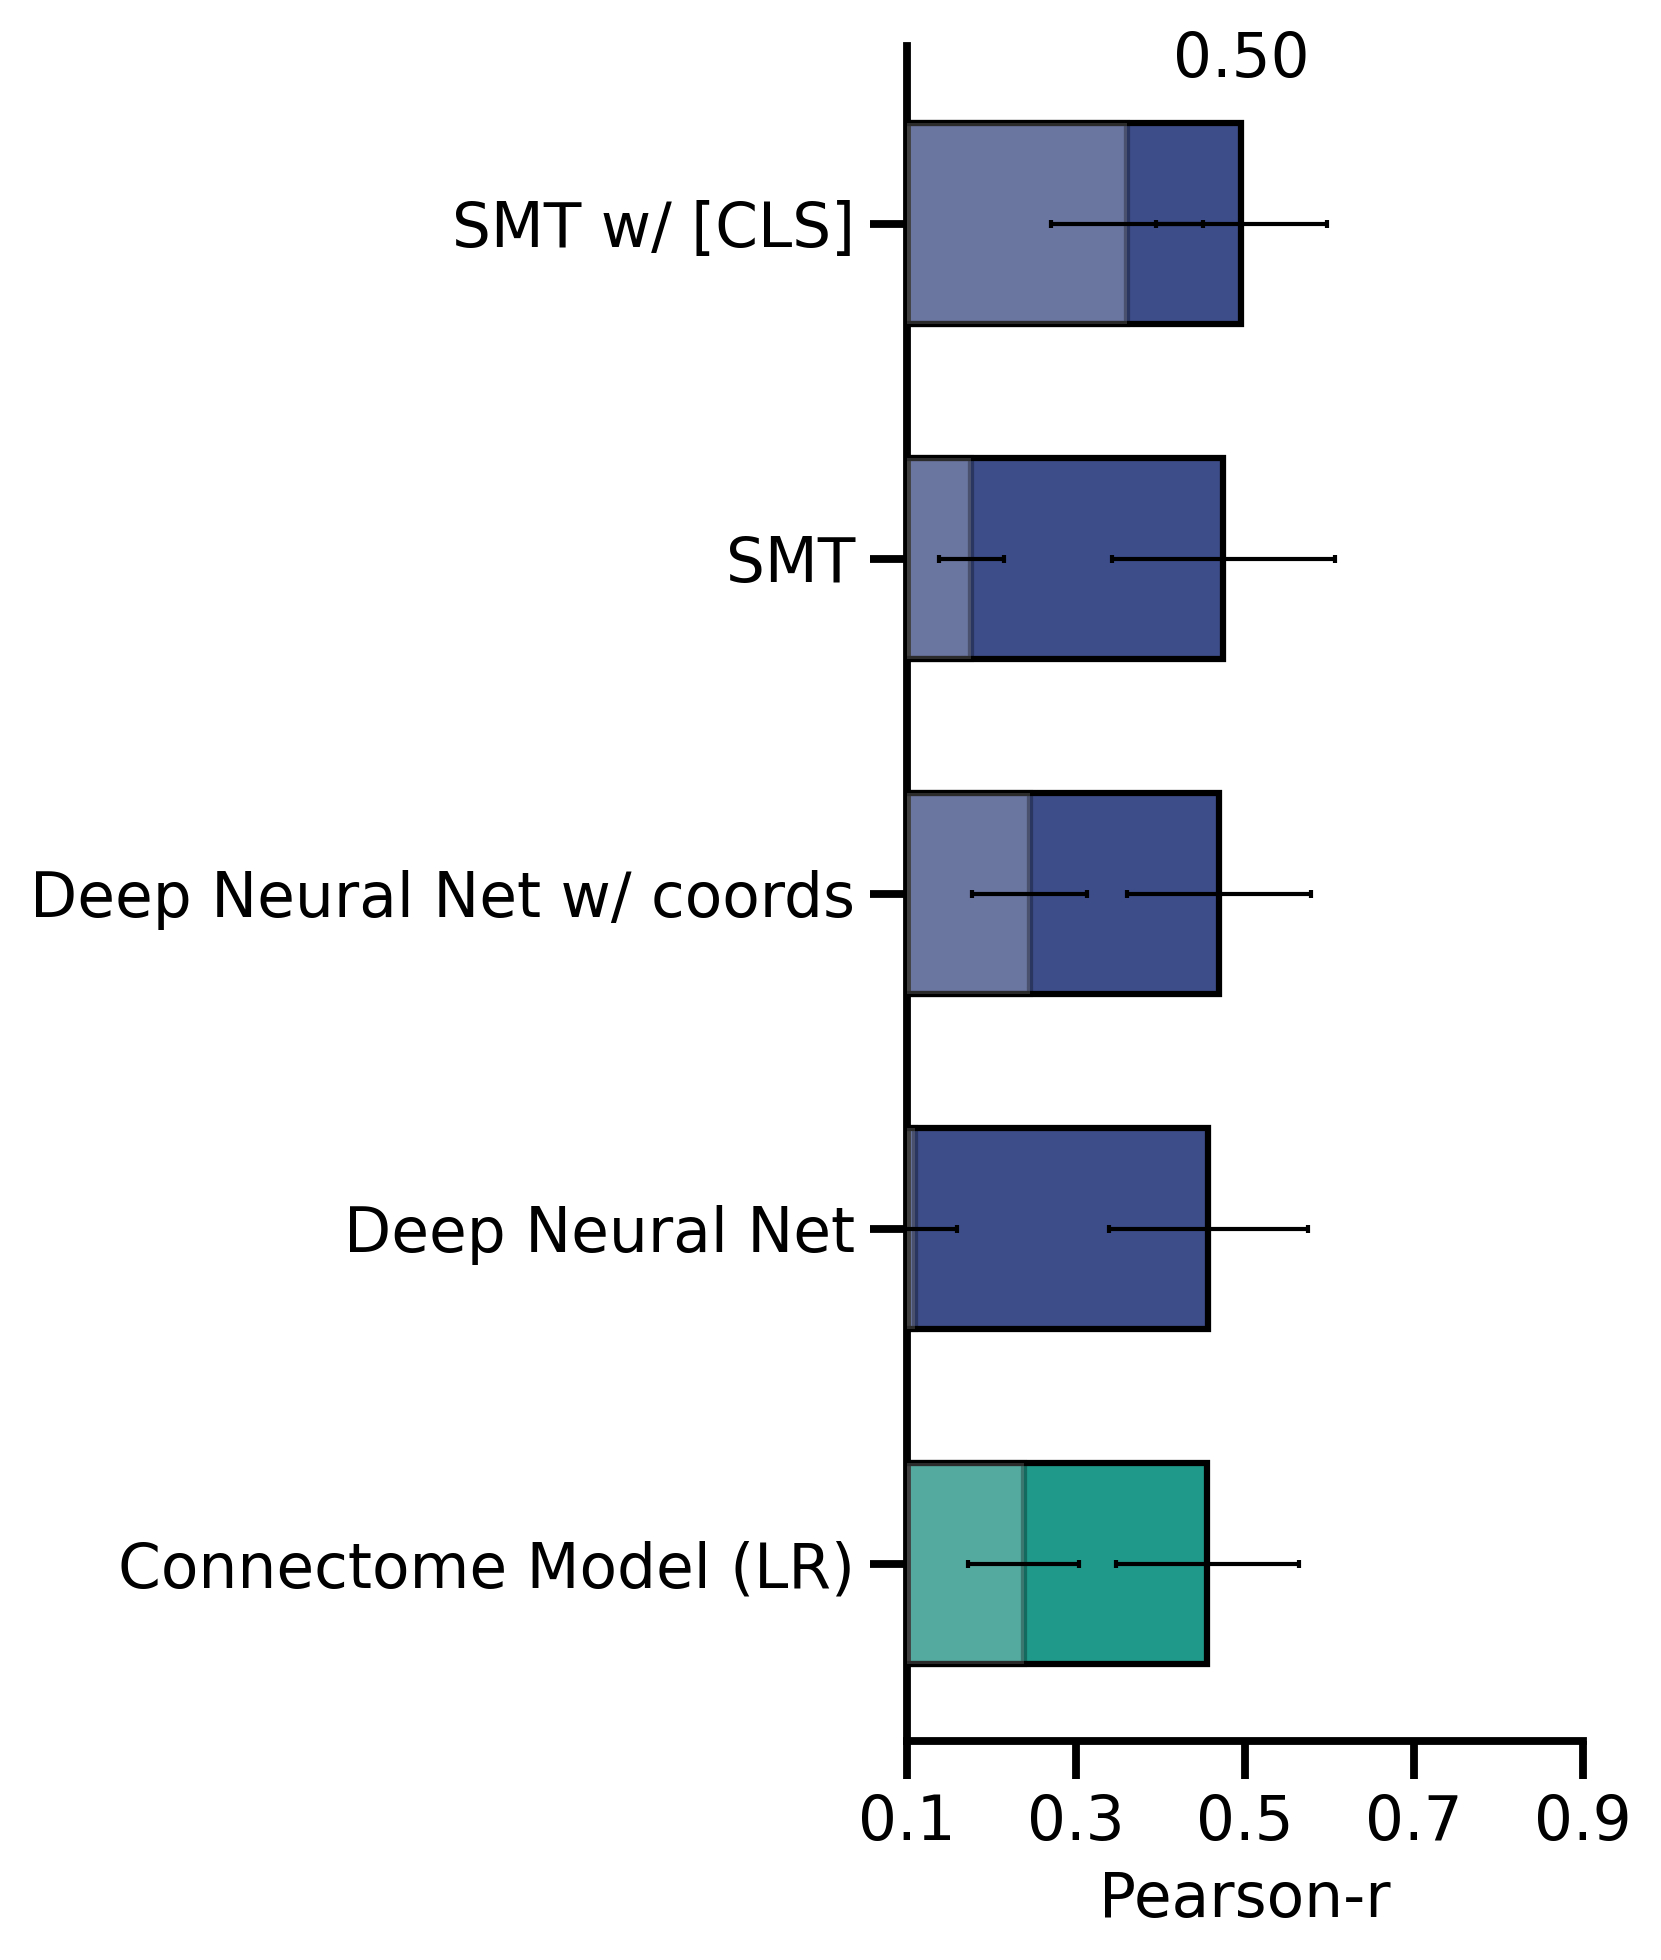

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [15]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_lobe,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_lobe_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

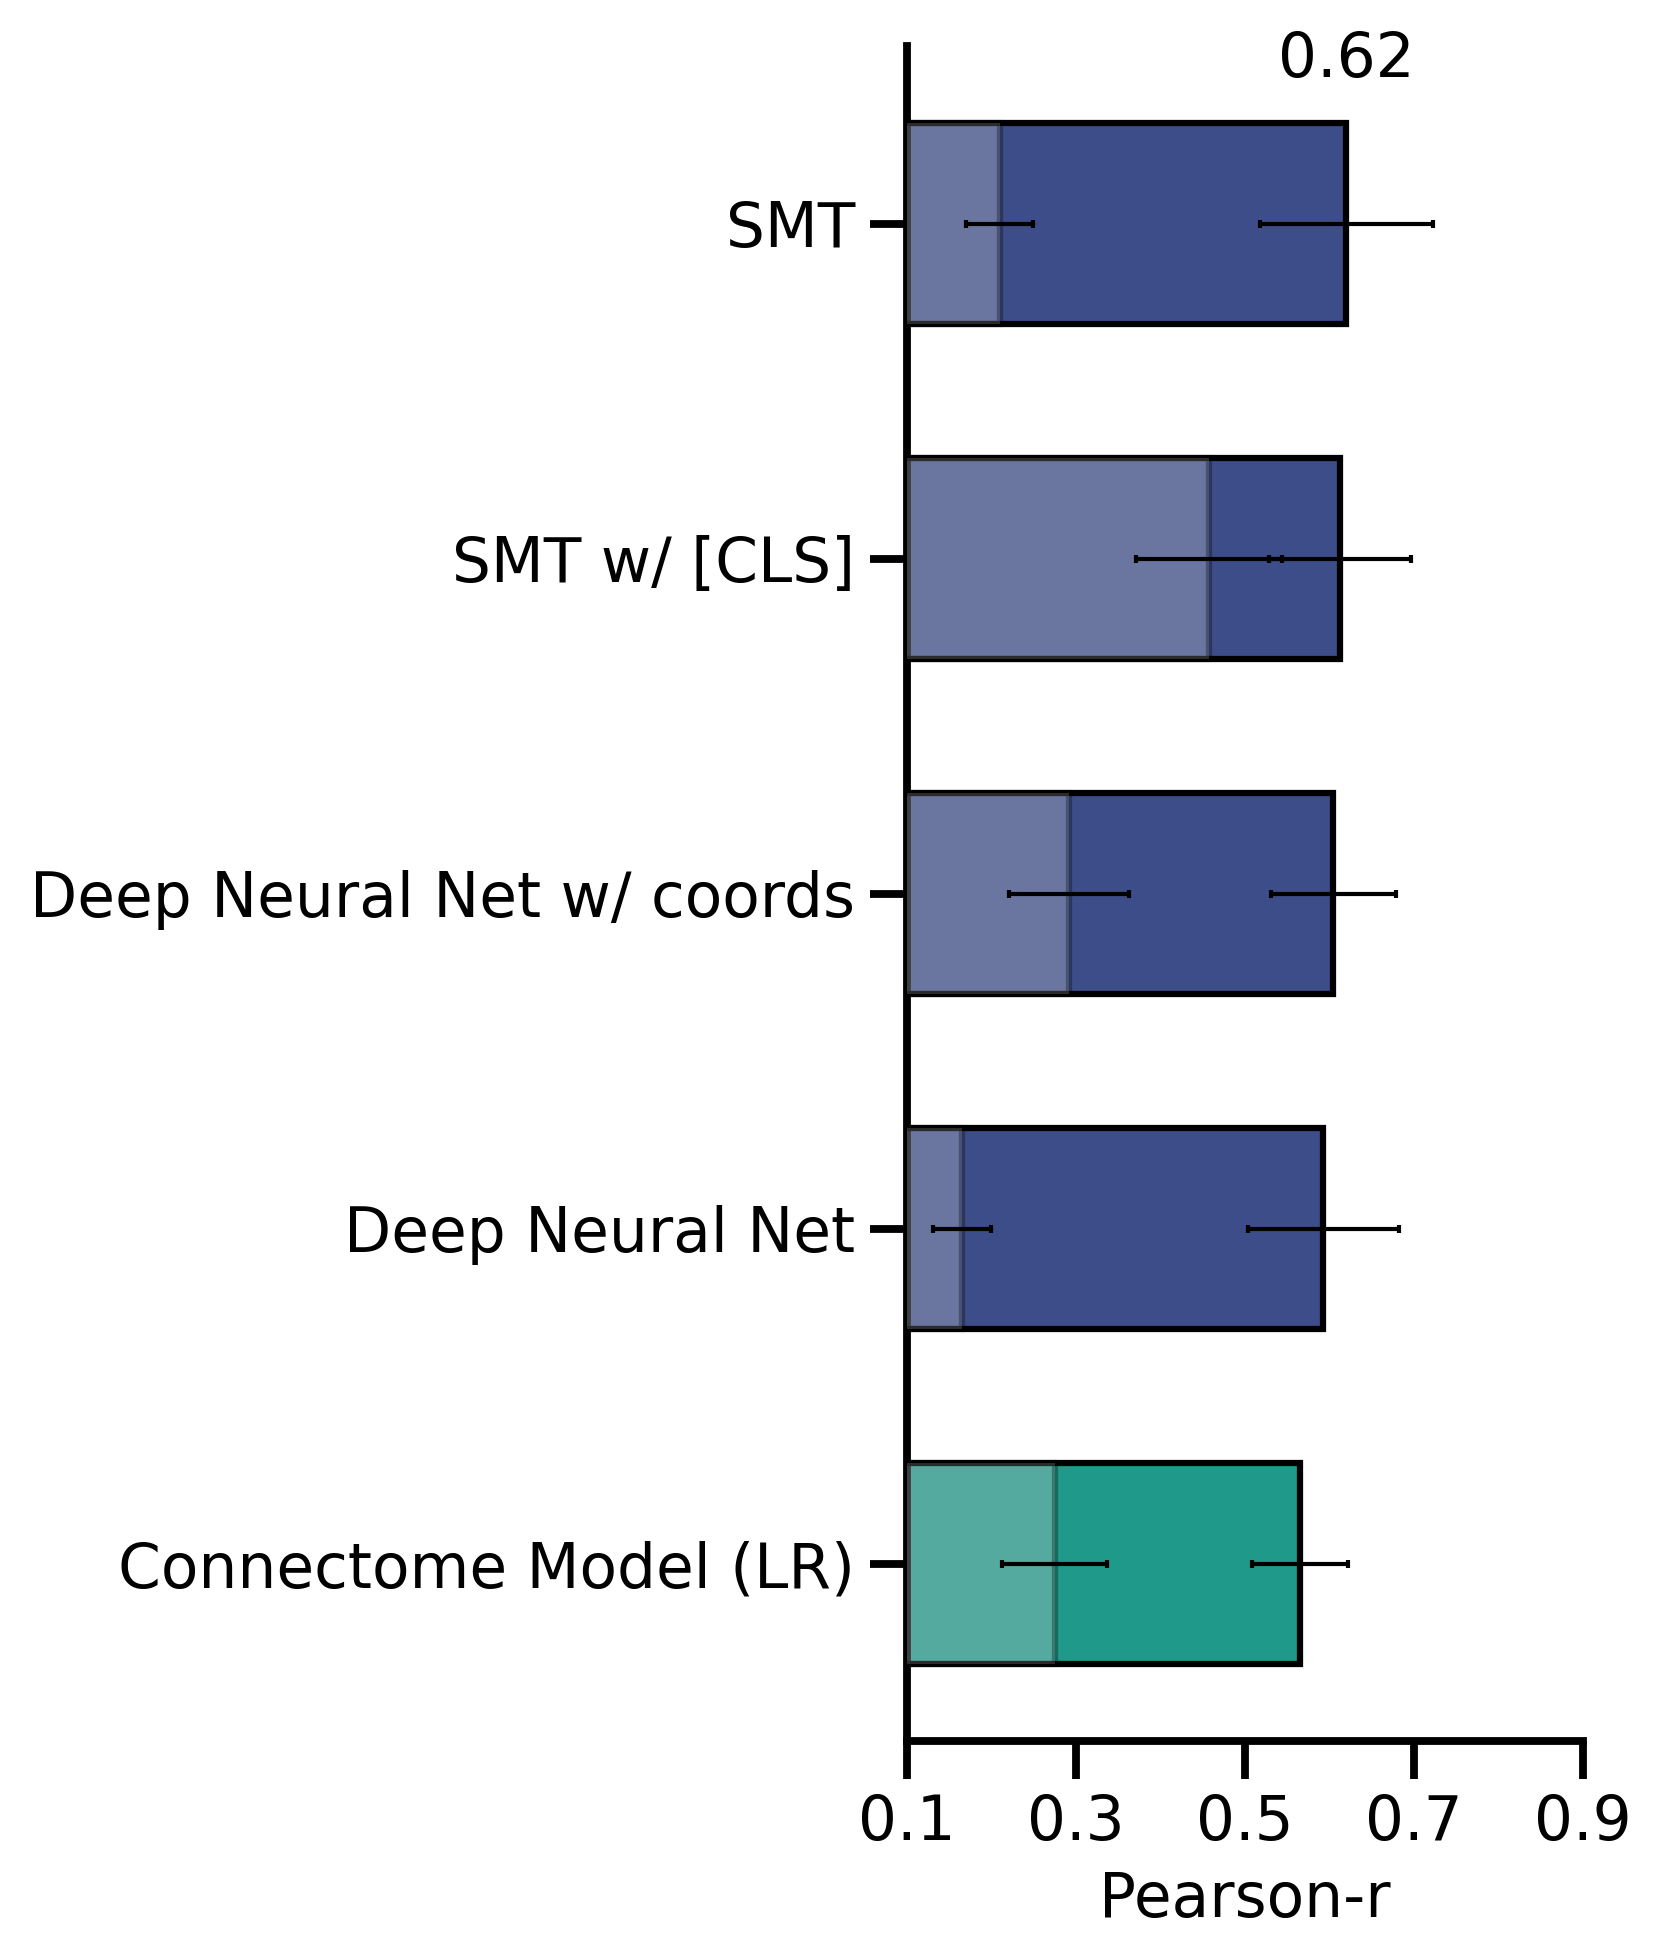

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [16]:
plot_true_vs_null_model_barchart_weighted(
    summary_true_dict=summary_dict_lobe,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_lobe_spin,           # cv_type='spatial', null_model='spin'
    metric="final_test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Heatmaps for UKBB vs HCP, SMT and SMT CLS

In [66]:
# Define shared parameters
params = {
    'model': 'shared_transformer',
    'cv_type': 'schaefer',
    'null_model': 'none',
    'feature_type': 'transcriptome',
    'days': 30,
    'use_weighted': True,
    'return_history': True
}

UKBB_SMT_df_weighted, UKBB_SMT_df = fetch_and_summarize_wandb_runs(**params, exclude='HCP')
HCP_SMT_df_weighted, HCP_SMT_df = fetch_and_summarize_wandb_runs(**params, exclude='UKBB')


🔍 Fetching runs for: model=shared_transformer, cv_type=schaefer, null_model=none, feature_type=transcriptome
🔍 Fetching runs for: model=shared_transformer, cv_type=schaefer, null_model=none, feature_type=transcriptome


In [67]:
# Define shared parameters
params = {
    'model': 'shared_transformer',
    'cv_type': 'schaefer',
    'null_model': 'spin',
    'feature_type': 'transcriptome',
    'days': 30,
    'use_weighted': True,
    'return_history': True
}

UKBB_SMT_df_weighted_spin, UKBB_SMT_df_spin = fetch_and_summarize_wandb_runs(**params, exclude='HCP')
HCP_SMT_df_weighted_spin, HCP_SMT_df_spin = fetch_and_summarize_wandb_runs(**params, exclude='UKBB')


🔍 Fetching runs for: model=shared_transformer, cv_type=schaefer, null_model=spin, feature_type=transcriptome
🔍 Fetching runs for: model=shared_transformer, cv_type=schaefer, null_model=spin, feature_type=transcriptome


In [68]:
subnetwork_labels = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical', 'Cerebellum']

def create_network_performance_matrix(df, subnetwork_labels):
    """Create 9x9 matrix of intra/inter network performance from dataframe and return summary metrics"""
    n = len(subnetwork_labels)
    pearson_matrix = np.zeros((n, n))
    intra_inter_matrix = np.zeros((n, 2))  # Column 0: intra, Column 1: avg inter
    
    # Iterate through each row in dataframe
    for i, (_, row) in enumerate(df.iterrows()):
        held_out_subnet = subnetwork_labels[i]
        print(held_out_subnet)
        # Get intra-network performance
        pearson_matrix[i,i] = row[f'test_intra_network_{held_out_subnet}_r']
        intra_inter_matrix[i,0] = pearson_matrix[i,i]
        
        # Get inter-network performances
        inter_performances = []
        for j, net2 in enumerate(subnetwork_labels):
            if i != j:
                pearson_matrix[i,j] = row[f'test_inter_network_{net2}_r']
                inter_performances.append(pearson_matrix[i,j])
        
        # Calculate average inter-network performance
        intra_inter_matrix[i,1] = np.mean(inter_performances)

    return pearson_matrix, intra_inter_matrix

# SMT 
ukbb_smt_subnetwork_pearson, ukbb_smt_intra_inter_matrix = create_network_performance_matrix(UKBB_SMT_df, subnetwork_labels)
hcp_smt_subnetwork_pearson, hcp_smt_intra_inter_matrix = create_network_performance_matrix(HCP_SMT_df, subnetwork_labels)

ukbb_smt_subnetwork_pearson_spin, ukbb_smt_intra_inter_matrix_spin = create_network_performance_matrix(UKBB_SMT_df_spin, subnetwork_labels)
hcp_smt_subnetwork_pearson_spin, hcp_smt_intra_inter_matrix_spin = create_network_performance_matrix(HCP_SMT_df_spin, subnetwork_labels)

# # CLS
# ukbb_smt_cls_subnetwork_pearson, ukbb_smt_cls_intra_inter_matrix = create_network_performance_matrix(UKBB_SMT_CLS_df, subnetwork_labels)
# hcp_smt_cls_subnetwork_pearson, hcp_smt_cls_intra_inter_matrix = create_network_performance_matrix(HCP_SMT_CLS_df, subnetwork_labels)


Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum
Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum
Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum
Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum


In [69]:
def plot_network_performance_matrix(performance_matrix, subnetwork_labels): 
    """Plot heatmap of network performance matrix for given dataframe"""
   
    
    # # Create custom colormap for performance matrix
    # colors = [
    #     (0.0, "yellow"),      # Low performance -> yellow
    #     (0.8, "green"),       # Medium performance -> green
    #     (1.0, "darkgreen")    # Excellent performance -> dark green
    # ]
    # cmap = mcolors.LinearSegmentedColormap.from_list("performance_cmap", colors)
    cmap='plasma'
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    ax = sns.heatmap(performance_matrix,
                xticklabels=subnetwork_labels,
                yticklabels=subnetwork_labels, 
                cmap=cmap,
                vmin=0,
                vmax=1,
                square=True,
                cbar_kws={'label': 'Pearson-r'},
                linecolor='black')

    # Add dashed box around diagonal elements
    for i in range(len(subnetwork_labels)):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, linestyle='--', color='black', linewidth=1.5))
        
    # Add solid lines between rows
    for i in range(len(subnetwork_labels) - 1):
        ax.axhline(y=i+1, color='black', linewidth=1.5)

    # Add outer border
    n = len(subnetwork_labels)
    ax.add_patch(plt.Rectangle((0, 0), n, n, fill=False, color='black', linewidth=2))

    plt.xlabel('Held-out target')
    plt.ylabel('Held-out source')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()



In [70]:
def plot_intra_inter_heatmap(intra_inter_matrix, subnetwork_labels, cls=False, weighted_mean=None):
    # Set global font size
    fontsize = 16
    
    # Set up the figure with high DPI
    plt.figure(figsize=(4, 5), dpi=300)
    
    # Create heatmap
    im = plt.imshow(intra_inter_matrix, cmap='YlOrRd_r', aspect='auto')
    # Add colorbar with smaller size and dynamic font
    cbar = plt.colorbar(im, label='Pearson-r', shrink=0.8) #, extend='max')
    # Set colorbar tick font size
    cbar.ax.tick_params(labelsize=fontsize-2)
    cbar.set_label('Pearson-r', fontsize=fontsize-2)
    # Set colorbar range
    im.set_clim(-0.2, 0.8)
    
    # Customize plot
    plt.ylabel('Test Network', fontsize=fontsize)

    # Set y-axis labels (subnetworks)
    plt.yticks(range(len(subnetwork_labels)), subnetwork_labels, fontsize=fontsize)
    
    # Set x-axis labels
    plt.xticks([0, 1], ['Intra', 'Inter'], fontsize=fontsize, rotation=45) #, ha='right')

    # Add weighted mean as title if provided
    if weighted_mean is not None:
        plt.title(f'Weighted Pearson-r: {weighted_mean:.2f}', 
                 fontsize=fontsize,
                 pad=10)
    
    plt.tight_layout()
    plt.show()

subnetwork_labels = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'FPN', 'Default', 'Subcortical', 'Cerebellum']



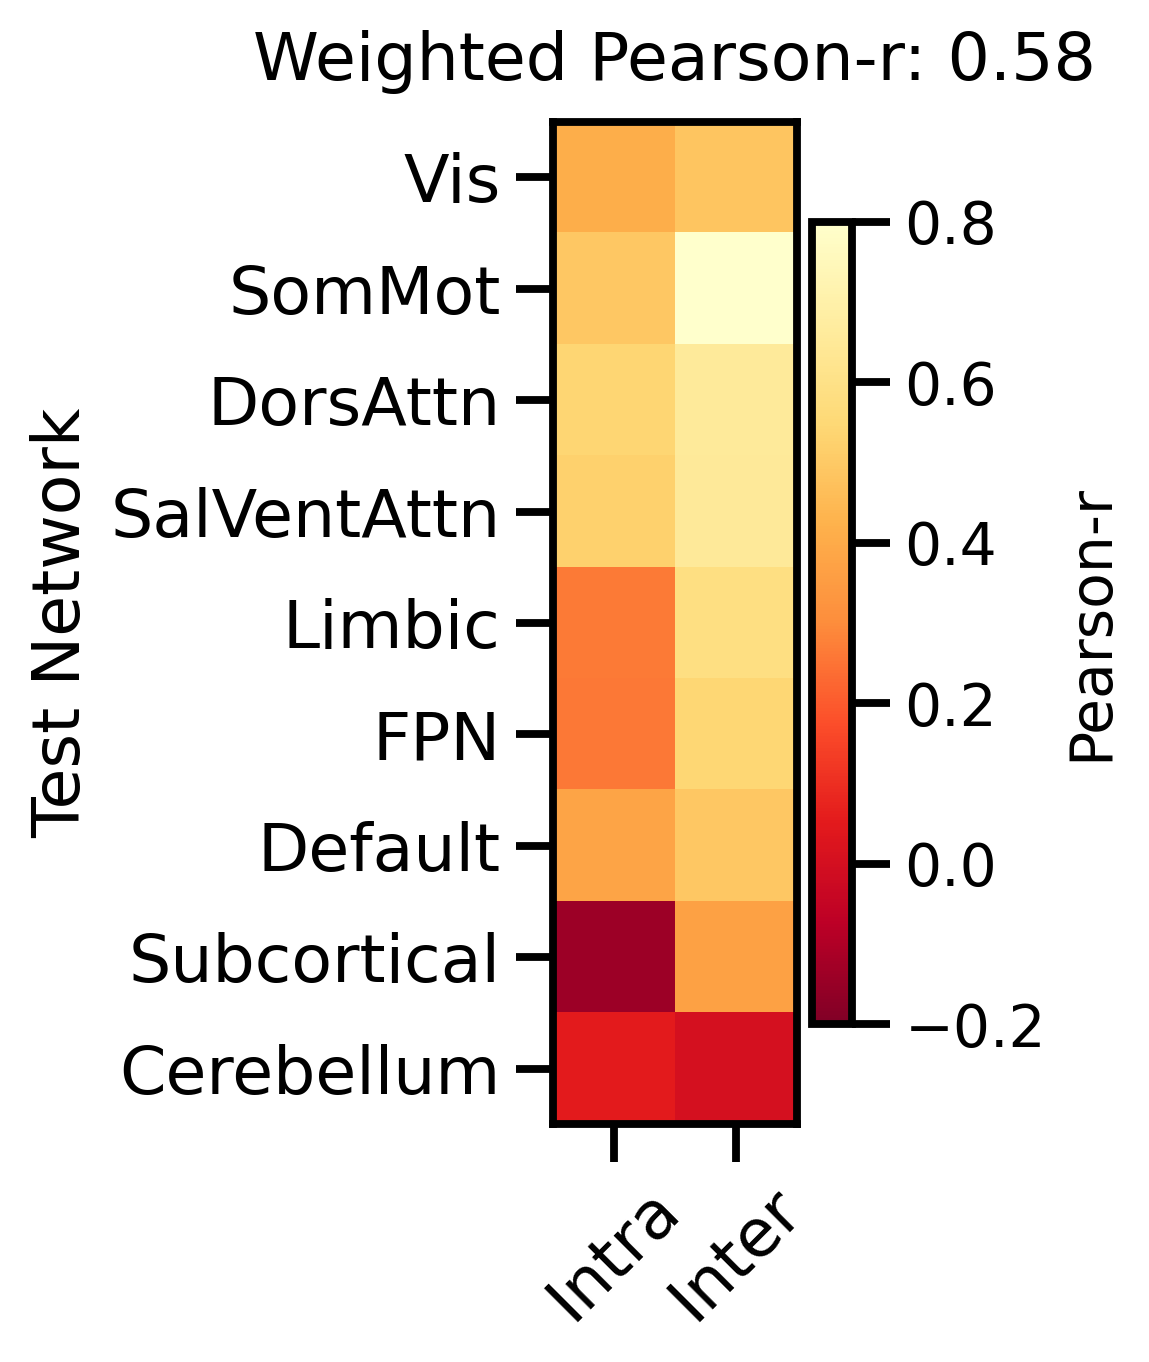

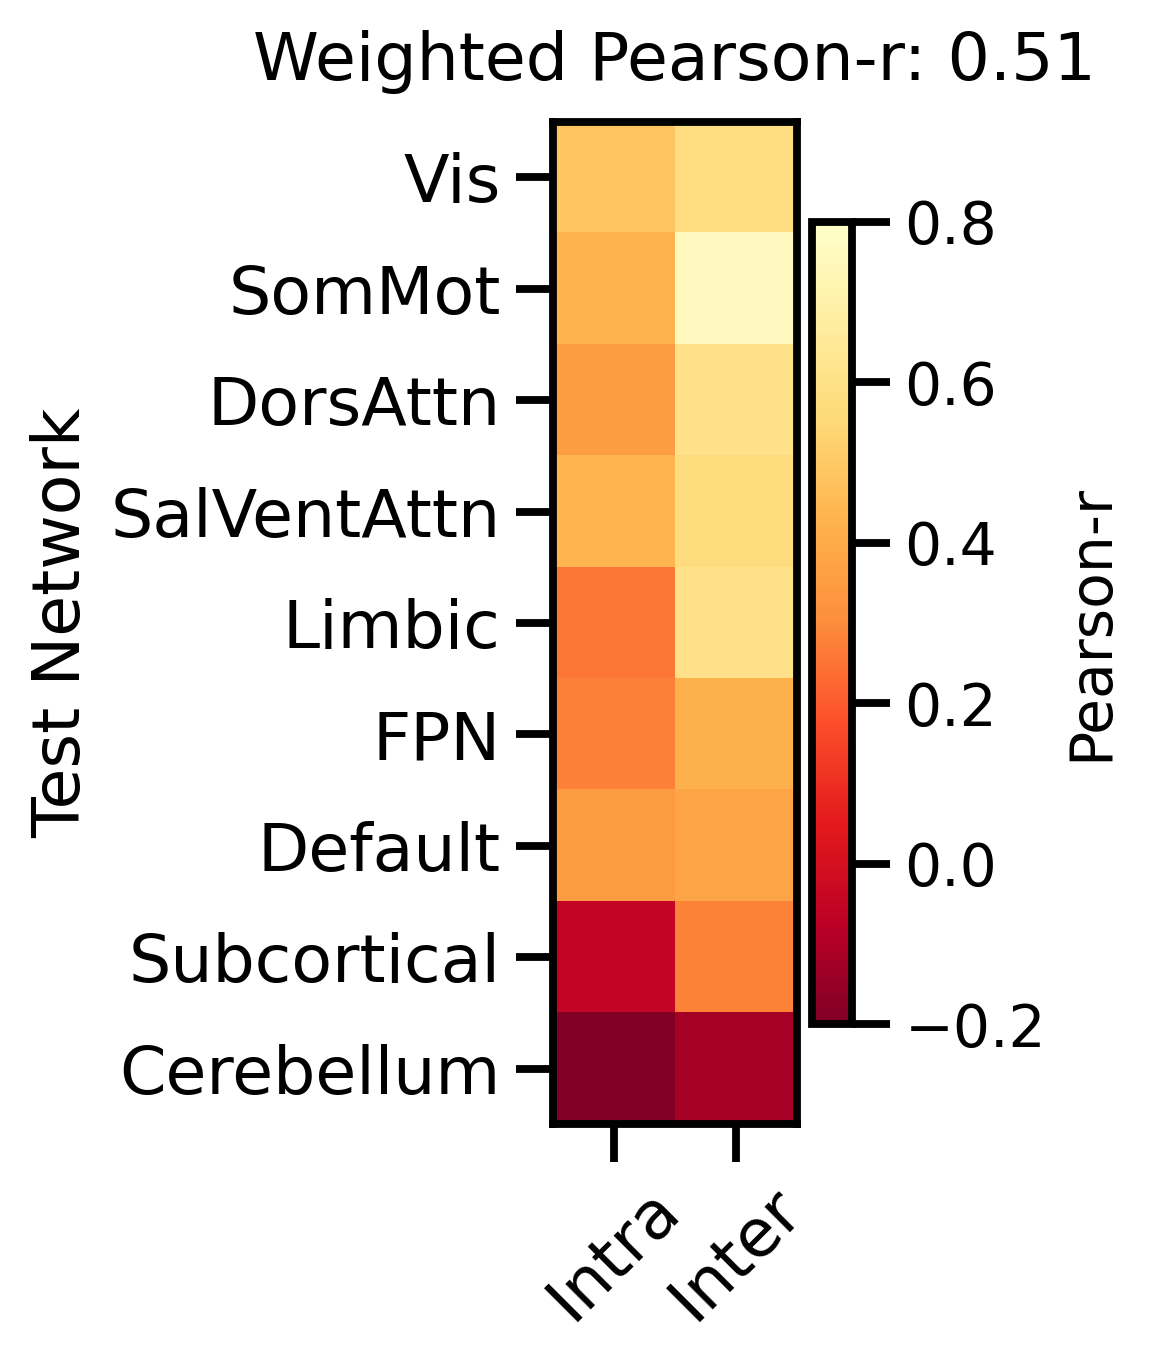

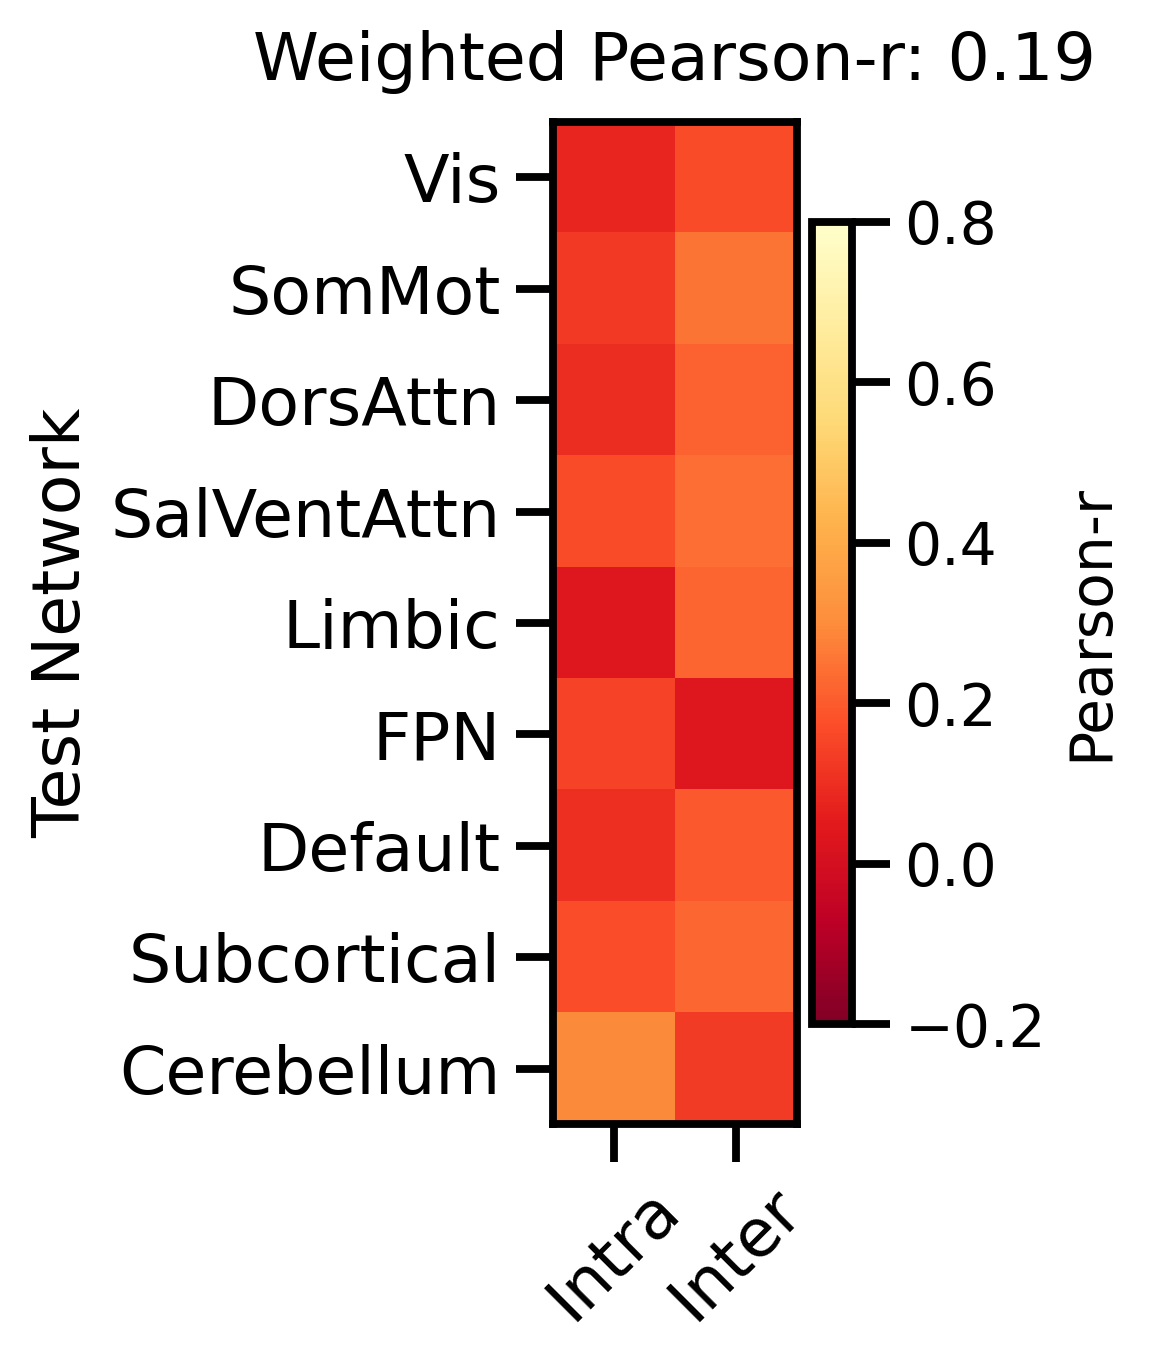

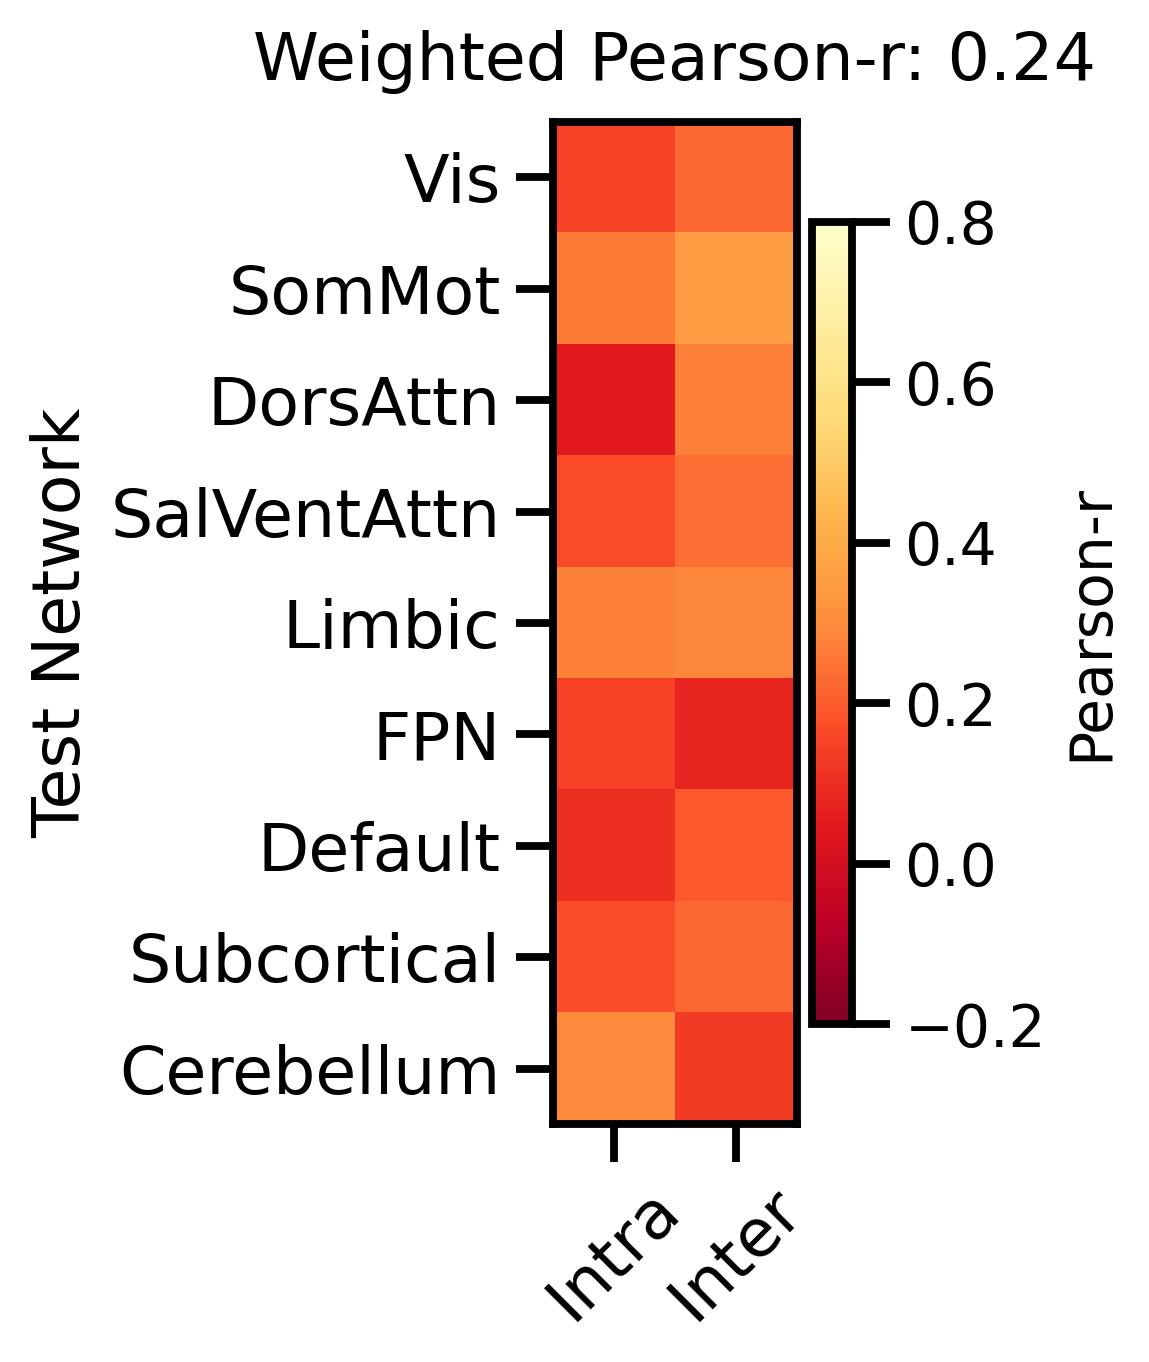

In [71]:
# Plot for each model's intra-inter matrix
plot_intra_inter_heatmap(ukbb_smt_intra_inter_matrix, subnetwork_labels, cls=False, weighted_mean=UKBB_SMT_df_weighted['final_test_pearson_r']['weighted_mean'])
plot_intra_inter_heatmap(hcp_smt_intra_inter_matrix, subnetwork_labels, cls=False, weighted_mean=HCP_SMT_df_weighted['final_test_pearson_r']['weighted_mean'])

plot_intra_inter_heatmap(ukbb_smt_intra_inter_matrix_spin, subnetwork_labels, cls=False, weighted_mean=UKBB_SMT_df_weighted_spin['final_test_pearson_r']['weighted_mean'])
plot_intra_inter_heatmap(hcp_smt_intra_inter_matrix_spin, subnetwork_labels, cls=False, weighted_mean=HCP_SMT_df_weighted_spin['final_test_pearson_r']['weighted_mean'])


SMT

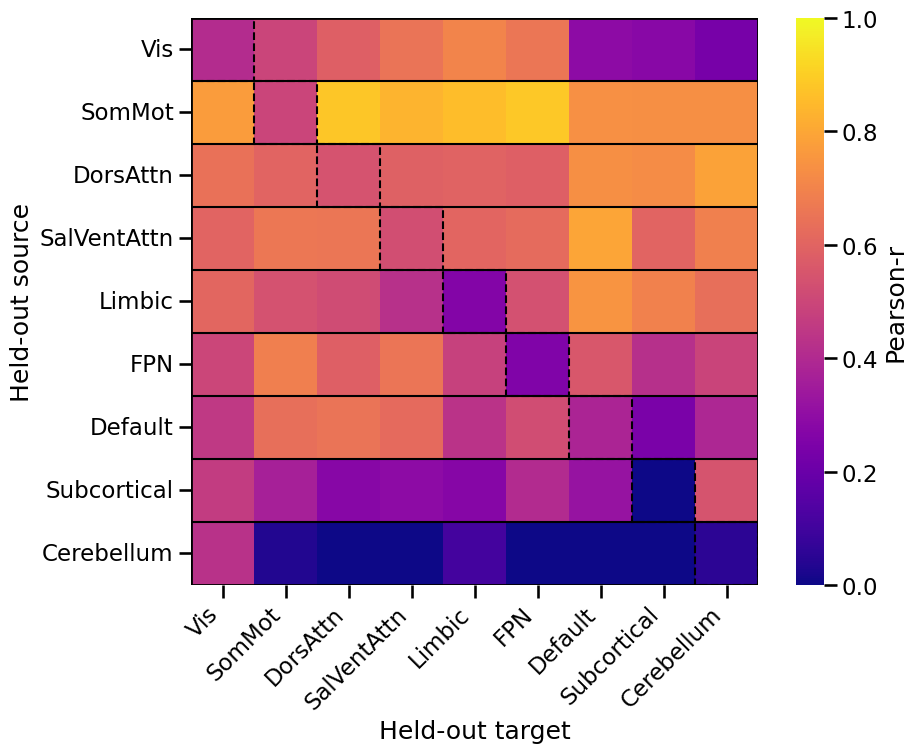

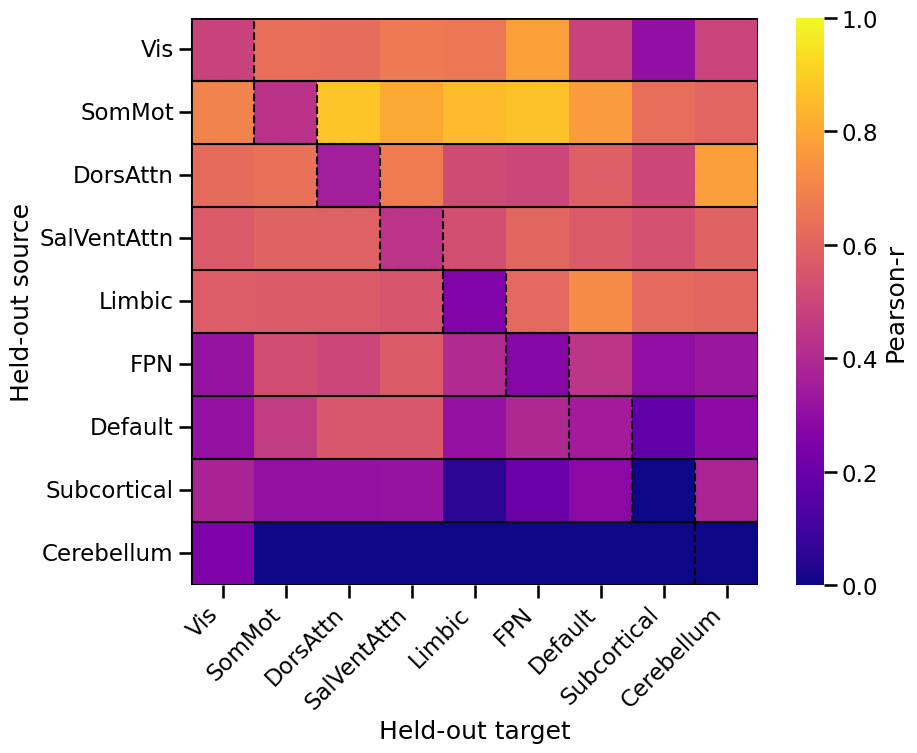

In [72]:
plot_network_performance_matrix(ukbb_smt_subnetwork_pearson, subnetwork_labels)
plot_network_performance_matrix(hcp_smt_subnetwork_pearson, subnetwork_labels)

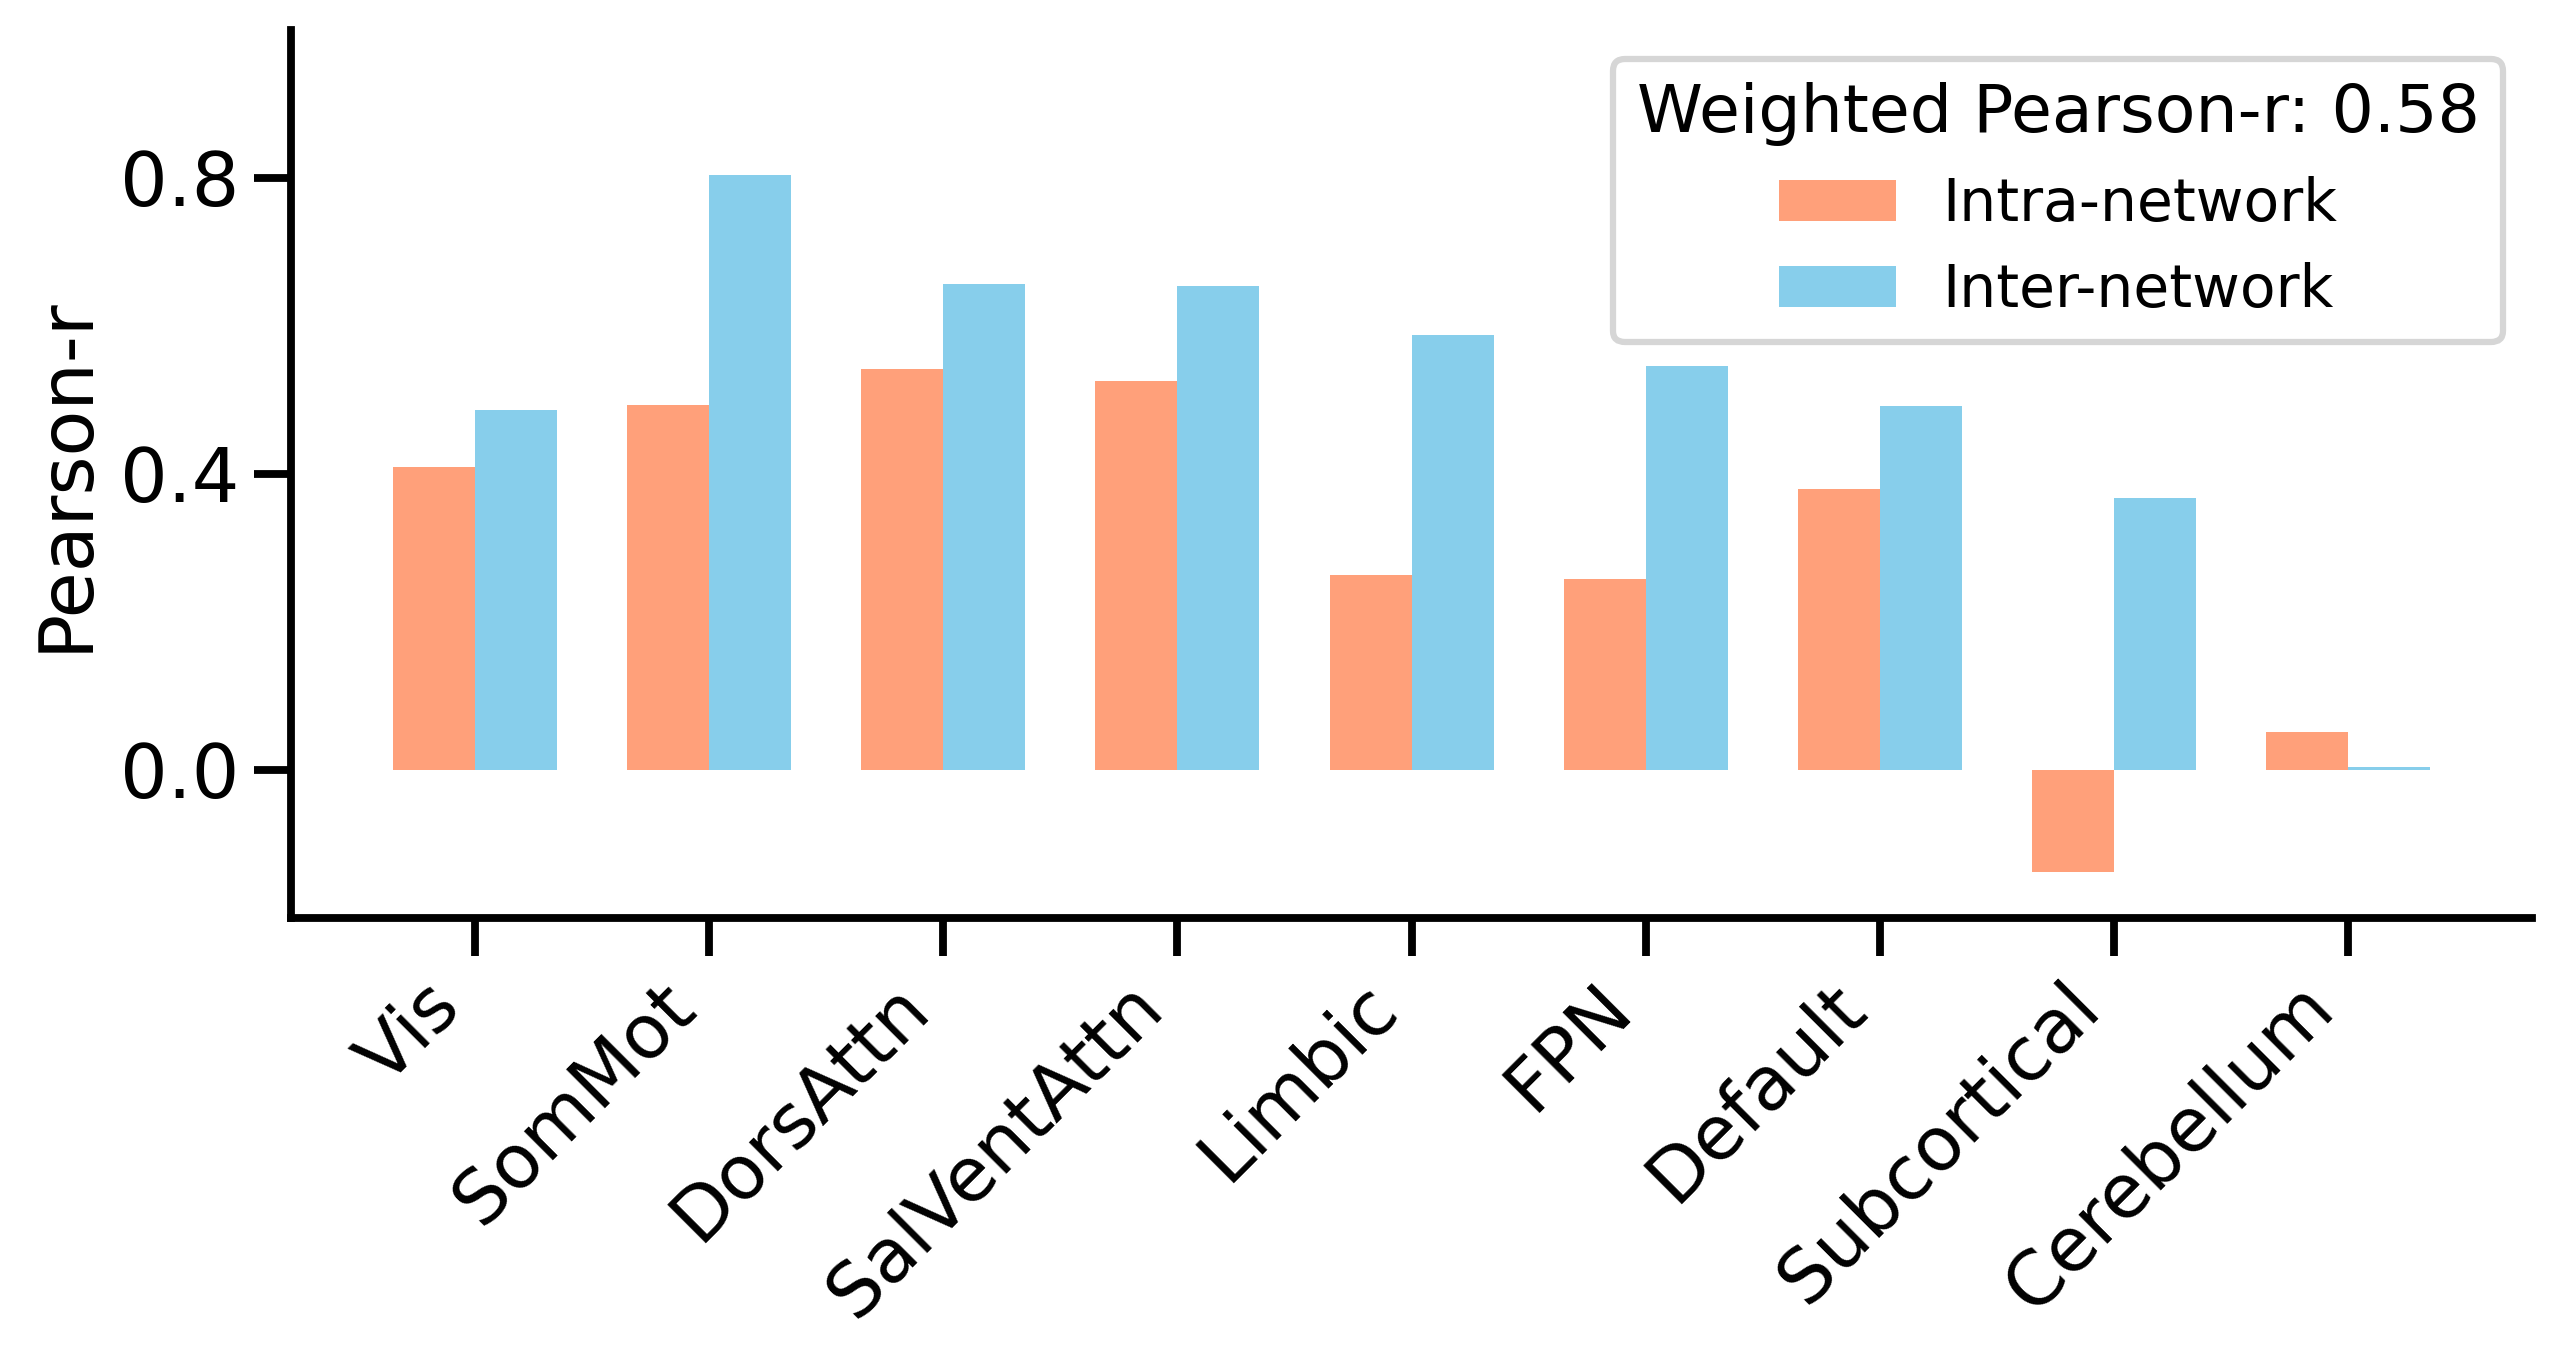

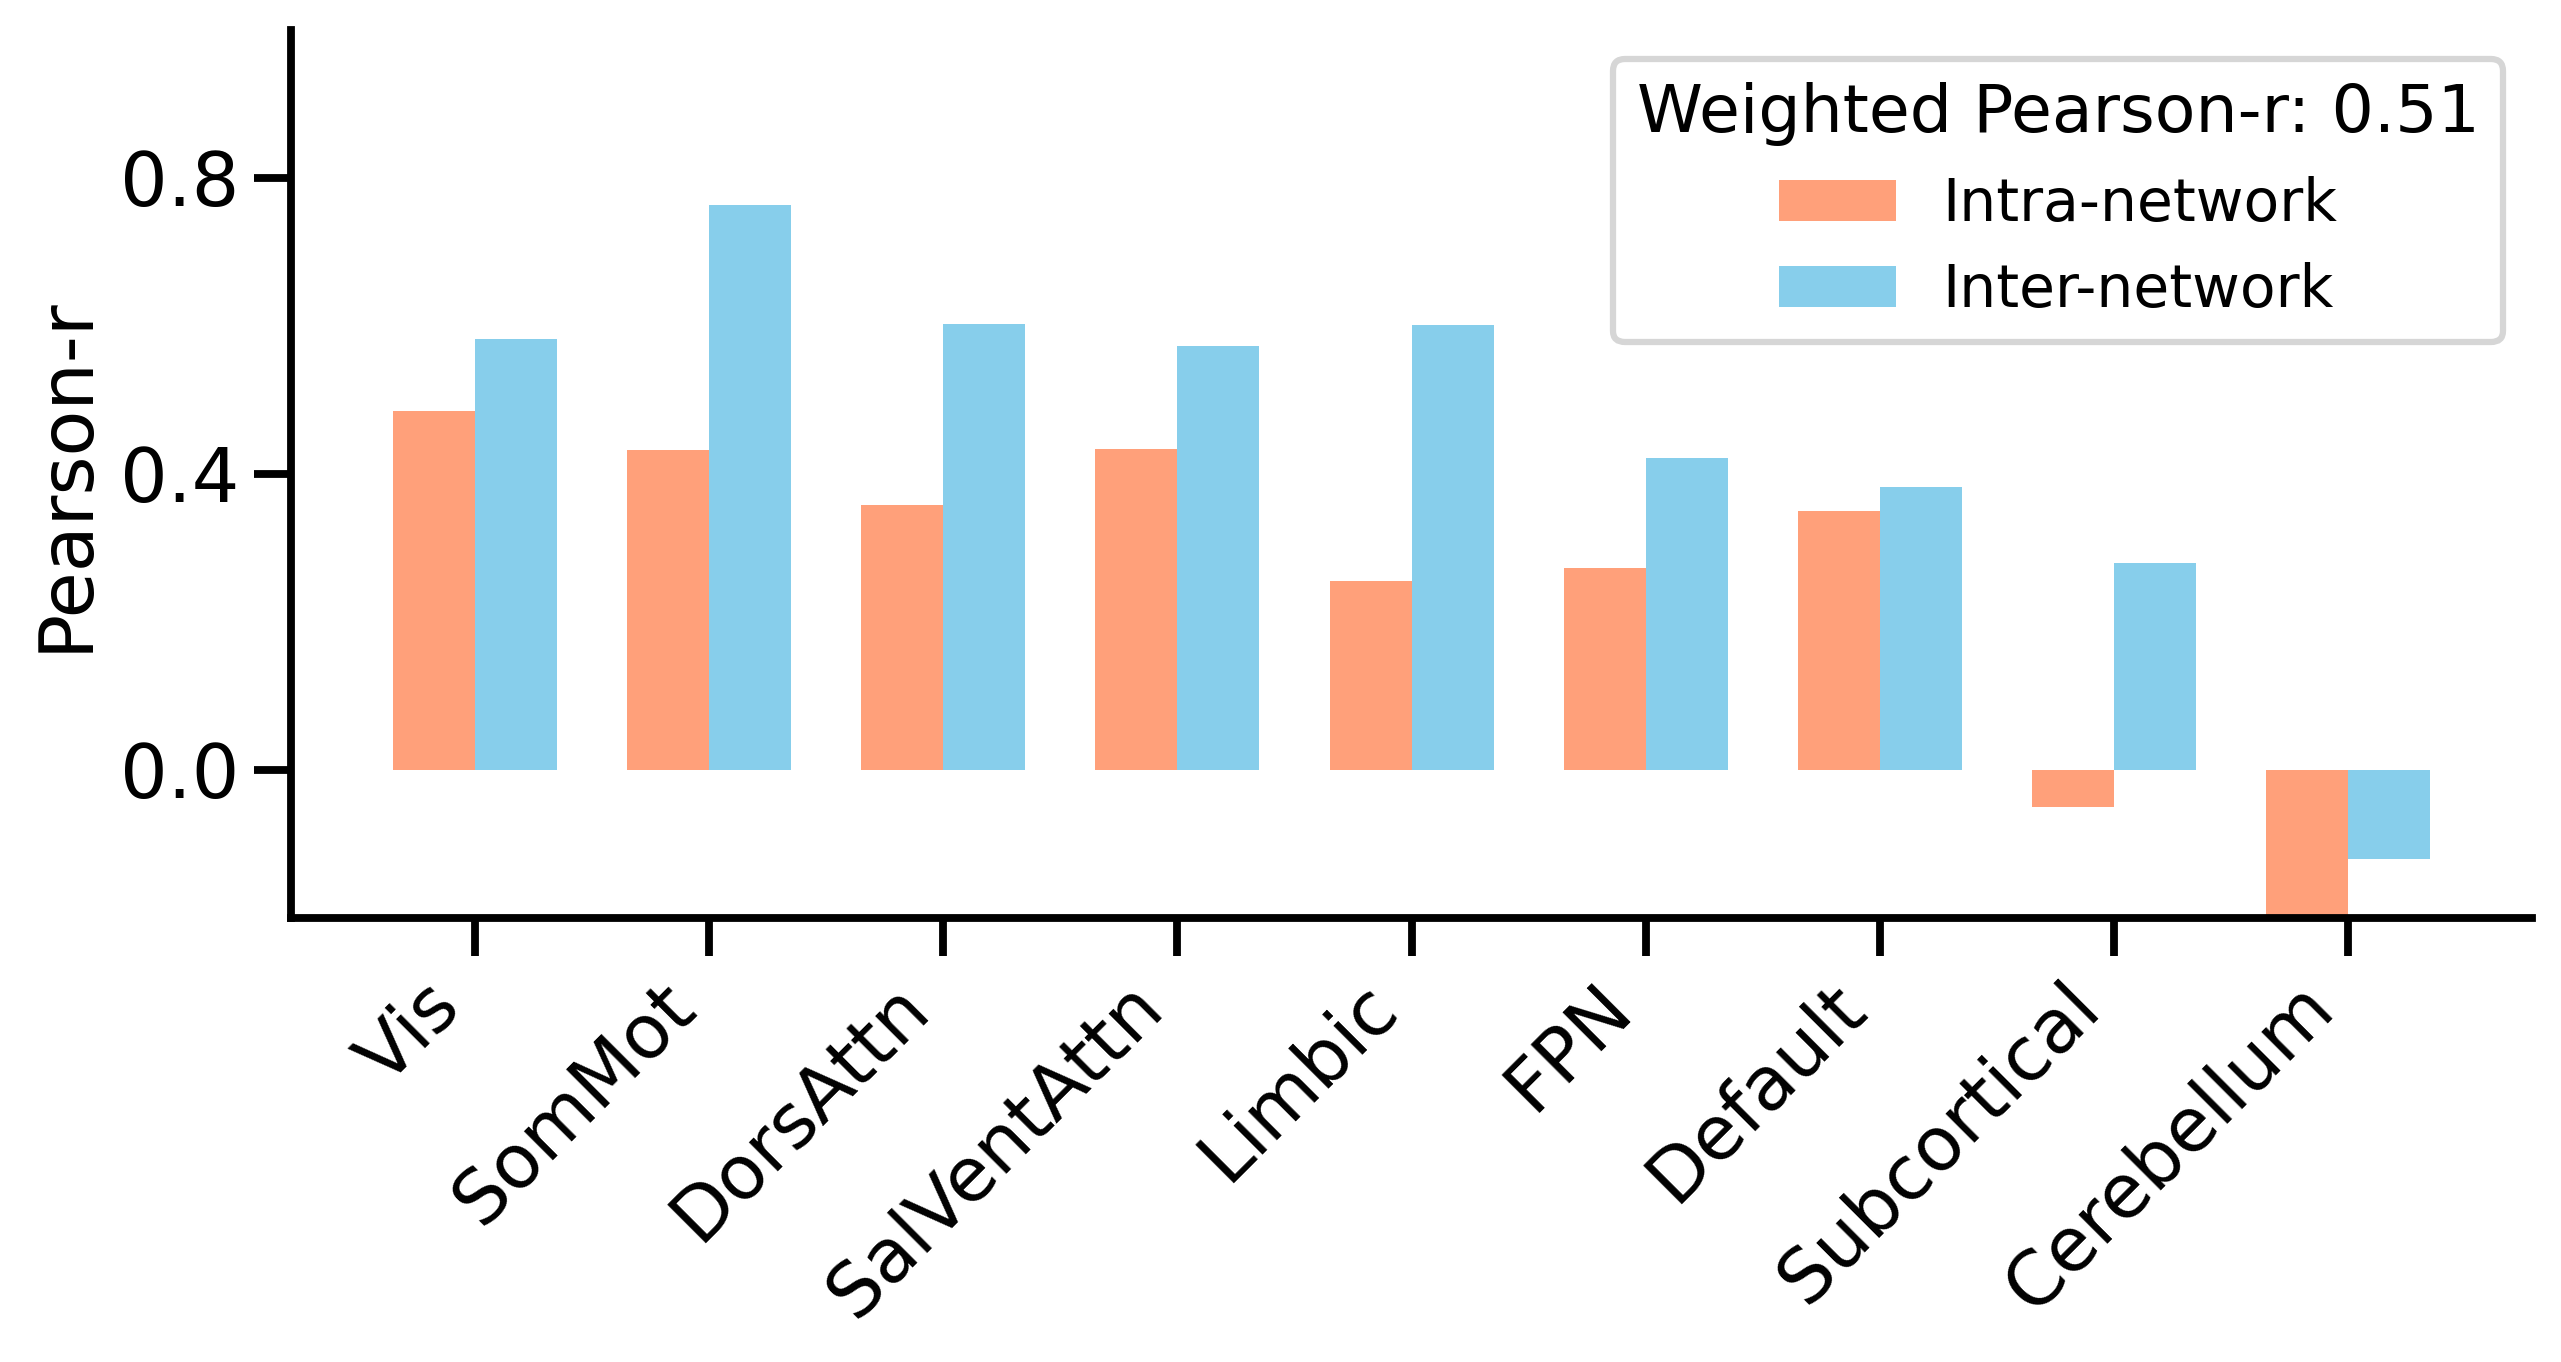

In [73]:
def plot_intra_inter_bars(intra_inter_matrix, subnetwork_labels, cls=False, weighted_mean=None):
    # Set global font size
    fontsize = 18
    
    # Set up the figure with high DPI
    plt.figure(figsize=(9, 5), dpi=300)
    
    # Number of subnetworks
    n_networks = len(subnetwork_labels)
    
    # Set up bar positions
    x = np.arange(n_networks)
    width = 0.35
    
    # Get intra and inter network values directly from matrix
    intra_vals = intra_inter_matrix[:,0]  # First column contains intra-network values
    inter_vals = intra_inter_matrix[:,1]  # Second column contains inter-network values
    
    # Create bars
    plt.bar(x - width/2, intra_vals, width, label='Intra-network', color='#FFA07A')
    plt.bar(x + width/2, inter_vals, width, label='Inter-network', color='skyblue')
    
    # Customize plot
    #plt.xlabel('Subnetworks', fontsize=fontsize)
    plt.ylabel('Pearson-r', fontsize=fontsize)

    if cls == False:
        plt.ylim(-0.2, 1.0)
    else: 
        plt.ylim(0, 1.0)

    plt.yticks([0, 0.4, 0.8], fontsize=fontsize)
    plt.xticks(x, subnetwork_labels, rotation=45, ha='right', fontsize=fontsize)
    
    # Remove box outline, keeping only x and y axis lines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add weighted mean to legend if provided
    if weighted_mean is not None:
        plt.legend(title=f'Weighted Pearson-r: {weighted_mean:.2f}', 
                  prop={'size': fontsize-4},
                  title_fontsize=fontsize-2,
                  loc='upper right')
    else:
        plt.legend(prop={'size': fontsize-2},
                  loc='upper right')
    
    plt.tight_layout()
    plt.show()

subnetwork_labels = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'FPN', 'Default', 'Subcortical', 'Cerebellum']
# Plot for each model's intra-inter matrix
plot_intra_inter_bars(ukbb_smt_intra_inter_matrix, subnetwork_labels, cls=False, weighted_mean=UKBB_SMT_df_weighted['final_test_pearson_r']['weighted_mean'])
plot_intra_inter_bars(hcp_smt_intra_inter_matrix, subnetwork_labels, cls=False, weighted_mean=HCP_SMT_df_weighted['final_test_pearson_r']['weighted_mean'])